### Sprint4 機械学習スクラッチ ロジスティク回帰
ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math

In [2]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
      
          """
    def __init__(self, num_iter, lr, no_bias, verbose,λ):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        self.λ = λ  # 正則化パラメータλはクラスを呼び出す時にself.λに代入するようにした。
    
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
        線形の仮定関数による推定結果

        """ 
        z = np.dot(X,self.theta)
        #シグモイド関数に入れる
        h = 1/(1+np.exp(-z))
        return h
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        m,n = X.shape
        
        # バイアスが無い場合は、Xデータはそのままで、Xデータの特徴量分のself.thetaを初期作成。
        if self.no_bias==True:
            self.theta = np.zeros(n) 
            self.theta = self.theta.reshape(-1,1)
            X = X
            self.y = y
        # バイアスが有る場合は、Xデータをバイアス項分の列を加え（各要素は1）、Xデータの列分のself.thetaを初期作成。   
        if self.no_bias==False:
            theta = np.zeros(n+1) 
            self.theta = theta.reshape(-1,1)
            ones = np.ones((m,1))
            X = np.hstack([ones,X])
            self.y = y
            # validationデータが入力されている場合、X_valにもバイアス項分の列を加える（各要素は1）
            if X_val is not None and y_val is not None:
                k = len(X_val)
                ones = np.ones((k,1))
                X_val = np.hstack([ones,X_val])
        
        # イテレーション回数分、elf.thetaを更新。その際目的関数もlossに記録
        for i in range(self.iter):
            error = self._linear_hypothesis(X)-y
            self.theta = self._gradient_descent(X,error)
            j_theta = self._cost_function(self._linear_hypothesis(X), y)
            self.loss[i] = j_theta
            #verboseがTrueの場合、学習過程を出力
            if self.verbose:
                print("{}回目：{}".format(i+1,j_theta) )  
            ## validationデータが入力されている場合、目的関数をval_lossに記録
            if X_val is not None and y_val is not None:
                    pred = self._linear_hypothesis(X_val)
                    j_theta_val = self._cost_function(pred, y_val)
                    self.val_loss[i] = j_theta_val
                
    def _gradient_descent(self, X, error):
        """
        各特徴量に相当するw（j）を計算する

        """
        
        m,n = X.shape 
        sigma = np.zeros((m,1))
        # j=0では正則化項はいらないので別で処理
        for i in range(m):
            sigma[0] = sigma[0]+(self._linear_hypothesis(X)[i]-self.y[i])*X[i][0]
        self.theta[0] = self.theta[0]-self.lr/m*sigma[0]
        # j=1移行は正則化項を加えて処理
        # 正則化パラメータλはクラスを呼び出す時にself.λに代入するようにした。 
        for j in range(1,n):
            for i in range(m):
                sigma[j] = sigma[j]+(self._linear_hypothesis(X)[i]-self.y[i])*X[i][j]
            self.theta[j] = self.theta[j]-self.lr/m*sigma[j] + self.λ/m*self.theta[j]
            
        return self.theta
            

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # 予測に入れたXが学習時のself.thetaの列と等しい場合、Xはそのまま
        if len(self.theta)==X.shape[1]:
            pass
        # 予測に入れたXが学習時のself.thetaの列と異なる場合（つまりbisaが有る場合）、Xに要素１の列を加える。
        else:
            k = len(X)
            ones = np.ones((k,1))
            X = np.hstack([ones,X])
        # 確率が0.5未満の場合は０を、0.5以上の場合は１を返す。
        return np.where(self.predict_proba(X) < 0.5, 0, 1)
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # 予測に入れたXが学習時のself.thetaの列と等しい場合、Xはそのまま
        if len(self.theta)==X.shape[1]:
            pass
        # 予測に入れたXが学習時のself.thetaの列と異なる場合（つまりbisaが有る場合）、Xに要素１の列を加える。
        else:
            k = len(X)
            ones = np.ones((k,1))
            X = np.hstack([ones,X])
        # 予測値（ベクトル）は、_linear_hypothesis()関数の返り値を返す。
        return self._linear_hypothesis(X)
    
    def _cost_function(self, pred, y):
        """
        目的関数の計算

        Parameters
        ----------
        pred : 次の形のndarray, shape (n_samples,)
          推定した値
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
          numpy.float
          平均二乗誤差
        """
        m = len(y)
        n = len(self.theta)
        
        siguma1 = 0
        siguma2 = 0
        
        # 目的関数の第１項目を計算
        for i in range(m):
            h = pred[i]
            siguma1 = siguma1 -y[i]*np.log(h)-(1-y[i])*np.log(1-h)
        
        # 目的関数の第２項目（L2項）を計算
        for j in range(n):
            siguma2 = siguma2 +self.theta[j]**2
        
        # 最後に係数含めて、足し合わせる。
        J =  1/m*siguma1 + self.λ/(2*m)*siguma2
        
        return J


$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$$


### 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。

$$
g(z) = \frac{1}{1+e^{−z}}.
$$

線形回帰の仮定関数は次の式でした。

$$
h_\theta(x) = \theta^T \cdot x.
$$

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

$$
h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}.
$$

$$ x : 特徴量ベクトル $$

$$\theta : パラメータ（重み）ベクトル$$ 

```python
def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
        線形の仮定関数による推定結果

        """ 
        z = np.dot(X,self.theta)
        #シグモイド関数に入れる
        h = 1/(1+np.exp(-z))
        return h
```

### 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}\\<br/>\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0\\<br/>\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1
$$

```python
     def _gradient_descent(self, X, error):
        """
        各特徴量に相当するw（j）を計算する

        """
        
        m,n = X.shape 
        sigma = np.zeros((m,1))
        # j=0では正則化項はいらないので別で処理
        for i in range(m):
            sigma[0] = sigma[0]+(self._linear_hypothesis(X)[i]-self.y[i])*X[i][0]
        self.theta[0] = self.theta[0]-self.lr/m*sigma[0]
        # j=1移行は正則化項を加えて処理
        # 正則化パラメータλはクラスを呼び出す時にself.λに代入するようにした。 
        for j in range(1,n):
            for i in range(m):
                sigma[j] = sigma[j]+(self._linear_hypothesis(X)[i]-self.y[i])*X[i][j]
            self.theta[j] = self.theta[j]-self.lr/m*sigma[j] + self.λ/m*self.theta[j]
            
        return self.theta
            
def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        m,n = X.shape
        
        # バイアスが無い場合は、Xデータはそのままで、Xデータの特徴量分のself.thetaを初期作成。
        if self.no_bias==True:
            self.theta = np.zeros(n) 
            self.theta = self.theta.reshape(-1,1)
            X = X
            self.y = y
            
        # バイアスが有る場合は、Xデータをバイアス項分の列を加え（各要素は1）、Xデータの列分のself.thetaを初期作成。 
        if self.no_bias==False:
            theta = np.zeros(n+1) 
            self.theta = theta.reshape(-1,1)
            ones = np.ones((m,1))
            X = np.hstack([ones,X])
            self.y = y
            # validationデータが入力されている場合、X_valにもバイアス項分の列を加える（各要素は1）
            if X_val is not None and y_val is not None:
                k = len(X_val)
                ones = np.ones((k,1))
                X_val = np.hstack([ones,X_val])
        
        # イテレーション回数分、elf.thetaを更新。その際目的関数もlossに記録
        for i in range(self.iter):
            error = self._linear_hypothesis(X)-y
            self.theta = self._gradient_descent(X,error)
            j_theta = self._cost_function(self._linear_hypothesis(X), y)
            self.loss[i] = j_theta
            #verboseがTrueの場合、学習過程を出力
            if self.verbose:
                print("{}回目：{}".format(i+1,j_theta) )  
            ## validationデータが入力されている場合、目的関数をval_lossに記録
            if X_val is not None and y_val is not None:
                    pred = self._linear_hypothesis(X_val)
                    j_theta_val = self._cost_function(pred, y_val)
                    self.val_loss[i] = j_theta_val
                            
```

### 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。



```python
def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # 予測に入れたXが学習時のself.thetaの列と等しい場合、Xはそのまま
        if len(self.theta)==X.shape[1]:
            pass
        # 予測に入れたXが学習時のself.thetaの列と異なる場合（つまりbisaが有る場合）、Xに要素１の列を加える。
        else:
            k = len(X)
            ones = np.ones((k,1))
            X = np.hstack([ones,X])
        # 確率が0.5未満の場合は０を、0.5以上の場合は１を返す。
        return np.where(self.predict_proba(X) < 0.5, 0, 1)
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # 予測に入れたXが学習時のself.thetaの列と等しい場合、Xはそのまま
        if len(self.theta)==X.shape[1]:
            pass
        # 予測に入れたXが学習時のself.thetaの列と異なる場合（つまりbisaが有る場合）、Xに要素１の列を加える。
        else:
            k = len(X)
            ones = np.ones((k,1))
            X = np.hstack([ones,X])
        # 予測値（ベクトル）は、_linear_hypothesis()関数の返り値を返す。
        return self._linear_hypothesis(X)
    
```

### 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


なお、この数式には正則化項が含まれています。


＊数式が見切れる場合、DIVERを全画面にして御覧ください。

$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$$


```python
def _cost_function(self, pred, y):
        """
        目的関数の計算

        Parameters
        ----------
        pred : 次の形のndarray, shape (n_samples,)
          推定した値
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
          numpy.float
          平均二乗誤差
        """
        m = len(y)
        n = len(self.theta)
        
        siguma1 = 0
        siguma2 = 0
        
        # 目的関数の第１項目を計算
        for i in range(m):
            h = pred[i]
            siguma1 = siguma1 -y[i]*np.log(h)-(1-y[i])*np.log(1-h)
        
        # 目的関数の第２項目（L2項）を計算
        for j in range(n):
            siguma2 = siguma2 +self.theta[j]**2
        
        # 最後に係数含めて、足し合わせる。
        J =  1/m*siguma1 + self.λ/(2*m)*siguma2
        
        return J
```

### 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [3]:
# irisデータ取得　
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[50:150]
y = iris.target[50:150].reshape(-1,1)
X = X[:,0:2] #今回はsetal length, setal width の特徴量を使う
#デフォルトであるとvirgicolor：1とvirginica:2なので、この後のラベル推定のためそれぞれvirgicolor：0, virginica:1にしておく
y[y == 1]= 0
y[y == 2]= 1

In [4]:
#　データの分割
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# スクラッチ関数で学習・予測を行う
Scrach_LR = ScratchLogisticRegression(num_iter=100, lr=0.1, no_bias=False, verbose=True,λ=0.01)
Scrach_LR.fit(X_train,y_train,X_test,y_test)

pred_lavel = Scrach_LR.predict(X_test)
pred_proba = Scrach_LR.predict_proba(X_test)

1回目：[0.6831684]
2回目：[0.67386856]
3回目：[0.66519904]
4回目：[0.65711383]
5回目：[0.64956969]
6回目：[0.64252616]
7回目：[0.63594556]
8回目：[0.62979291]
9回目：[0.62403585]
10回目：[0.61864447]
11回目：[0.61359123]
12回目：[0.60885079]
13回目：[0.60439984]
14回目：[0.60021696]
15回目：[0.5962825]
16回目：[0.5925784]
17回目：[0.58908809]
18回目：[0.58579636]
19回目：[0.58268924]
20回目：[0.57975387]
21回目：[0.57697845]
22回目：[0.57435213]
23回目：[0.57186491]
24回目：[0.56950757]
25回目：[0.56727163]
26回目：[0.56514926]
27回目：[0.56313322]
28回目：[0.56121683]
29回目：[0.5593939]
30回目：[0.5576587]
31回目：[0.55600594]
32回目：[0.55443068]
33回目：[0.55292837]
34回目：[0.55149475]
35回目：[0.55012588]
36回目：[0.54881809]
37回目：[0.54756794]
38回目：[0.54637226]
39回目：[0.54522805]
40回目：[0.54413254]
41回目：[0.54308314]
42回目：[0.5420774]
43回目：[0.54111305]
44回目：[0.54018795]
45回目：[0.53930011]
46回目：[0.53844765]
47回目：[0.53762881]
48回目：[0.53684192]
49回目：[0.53608543]
50回目：[0.53535788]
51回目：[0.53465789]
52回目：[0.53398415]
53回目：[0.53333544]
54回目：[0.5327106]
55回目：[0.53210853]
56回目：[0.53152822]
57回目：[0.

In [6]:
# Scrachの予測結果の評価
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

print("accuracy_score:{}".format(accuracy_score(y_test,pred_lavel)))
print("precision_score:{}".format(precision_score(y_test,pred_lavel)))
print("recall_score:{}".format(recall_score(y_test,pred_lavel)))
print("f1_score:{}".format(f1_score(y_test,pred_lavel)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,pred_lavel)))

accuracy_score:0.6
precision_score:0.7777777777777778
recall_score:0.4666666666666667
f1_score:0.5833333333333334
confusion_matrix:
[[8 2]
 [8 7]]


In [7]:
# Sklearn で学習・予測を行う
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=100,C=100)
LR.fit(X_train,y_train)

pred_lavel_LR = LR.predict(X_test)
pred_proba_LR = LR.predict_proba(X_test)[:,1]

/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mishibatoshihiro/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
# sklearnの予測結果の評価
print("accuracy_score:{}".format(accuracy_score(y_test,pred_lavel_LR)))
print("precision_score:{}".format(precision_score(y_test,pred_lavel_LR)))
print("recall_score:{}".format(recall_score(y_test,pred_lavel_LR)))
print("f1_score:{}".format(f1_score(y_test,pred_lavel_LR)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,pred_lavel_LR)))

accuracy_score:0.6
precision_score:0.7777777777777778
recall_score:0.4666666666666667
f1_score:0.5833333333333334
confusion_matrix:
[[8 2]
 [8 7]]


In [9]:
# 各モデルの予測ラベルと正解ラベルを表示
print("Scrach_pred{}".format(pred_lavel.reshape(1,-1)))
print("LR_pred{}".format(pred_lavel_LR.reshape(1,-1)))
print("Accuracy{}".format(y_test.reshape(1,-1)))

Scrach_pred[[1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
LR_pred[[1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
Accuracy[[1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0]]


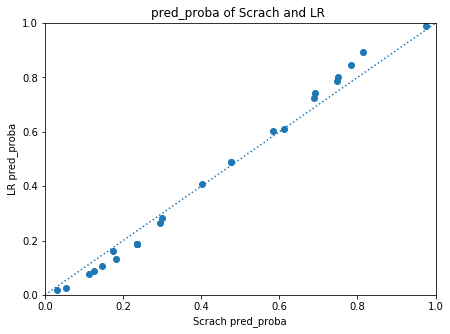

In [10]:
# 各モデルの予測値をグラフ化
plt.figure(figsize=(7,5))
plt.scatter(pred_proba,pred_proba_LR)
plt.title("pred_proba of Scrach and LR ")
plt.xlabel("Scrach pred_proba")
plt.ylabel("LR pred_proba")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle="dotted")

各モデルの予測ラベルと本グラフの予測確率の結果からスクラッチとSklearnによる学習・予測はほぼ同じことを行えていることを確認できた。

### 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

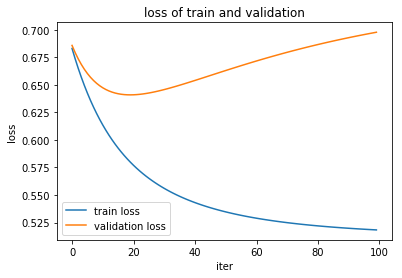

In [11]:
plt.plot(Scrach_LR.loss,label="train loss")
plt.plot(Scrach_LR.val_loss,label="validation loss")
plt.title("loss of train and validation")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.show()

今回の学習結果でもtrain lossは減少していくことを確認できた。しかし、validation lossは少し上昇してしまった。これは、データが少ないのもあり、train dataにフィットしすぎて過学習している可能性があると考えられる。

### 【問題7】決定領域の可視化
決定領域を可視化してください。

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [13]:
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

Train Data


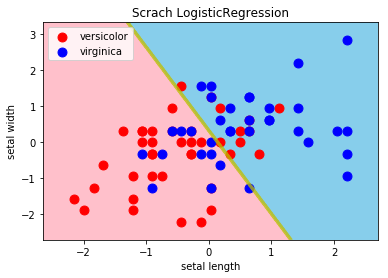

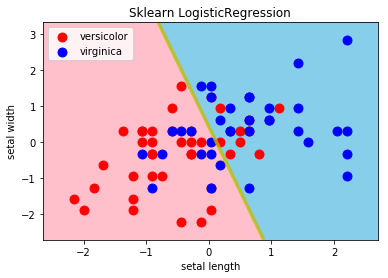

------------------------------------------------
Test Data


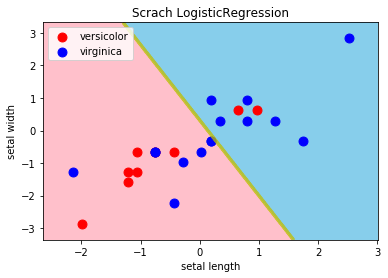

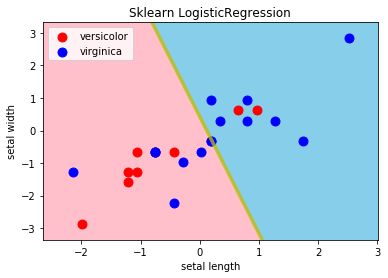

In [14]:
# 学習したそれぞれをtrain data及びtest dataで分けて比較
print("Train Data")
decision_region(X_train, y_train, Scrach_LR, step=0.01, title='Scrach LogisticRegression', xlabel='setal length', ylabel='setal width', target_names=['versicolor', 'virginica'])
decision_region(X_train, y_train, LR, step=0.01, title='Sklearn LogisticRegression', xlabel='setal length', ylabel='setal width', target_names=['versicolor', 'virginica'])
print("------------------------------------------------")
print("Test Data")
decision_region(X_test, y_test, Scrach_LR, step=0.01, title='Scrach LogisticRegression', xlabel='setal length', ylabel='setal width', target_names=['versicolor', 'virginica'])
decision_region(X_test, y_test, LR, step=0.01, title='Sklearn LogisticRegression', xlabel='setal length', ylabel='setal width', target_names=['versicolor', 'virginica'])

**上図からスクラッチとSklearn はある程度同様のモデル学習と予測をしていることが確認できた。**

### 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。



In [15]:
#Scrach と　Sklearn の重み結果を形を整えてnp.savez で保存・読み込みをする。
#まずは保存
Scrach_LR = Scrach_LR.theta.reshape(1,-1)
np.savez("theta_Scrach_LR",coef_ = Scrach_LR)

In [16]:
#まずは保存読み込み
npz_file = np.load("theta_Scrach_LR.npz")
npz_file["coef_"]

array([[-0.14072225,  1.01383487,  0.43750099]])

**学習データを保存・読み込みを行うことができた。**